# Temperature - precipitation scaling 

Investigating changes of extreme precipitation with increases in temperature and moisture. 


In [2]:
import numpy as np 
import xarray as xr 
import atmotrans as atm
import matplotlib.pyplot as plt 
import glob

# elevation 
dem = '/media/juli/Data/projects/data/elevation/elevation_600x350.nc'
elevations = xr.open_dataarray(dem)
la = elevations.lat.values
lo = elevations.lon.values
elevations.close()

## Changes in tcwv and surface humidity  ERA5 vs. WRF9km 

In [73]:
# calculate tcwv
for y in np.arange(1980,2018):
    f_q = xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/monthly/wrf_mean_q_pressure_'+str(y)+'.nc')
    f_sp = xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/monthly/wrfout_'+str(y)+'_sp.nc')
    mixr = f_q.mixr[0].values  
    sp = f_sp.ps[0].values 
    q= np.nan_to_num(mixr, 0)
    colint = atm.column_integration(np.flip(f_q.pressure.values, axis = 0), sp, np.flip(q, axis =0 ))
    tcwv_x = xr.DataArray(colint)
    tcwv_x.to_netcdf('/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/tcwv_'+str(y)+'.nc')


In [68]:
# calculate near surface humidity for annual files 
for y in np.arange(1980,2018):
    f_td = xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/monthly/wrfout_'+str(y)+'_td.nc')
    f_sp = xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/monthly/wrfout_'+str(y)+'_sp.nc')
    td = f_td.T2m[0].values  + 273.15
    sp = f_sp.ps[0].values 
    q_surface = atm.get_surface_humidity(td, sp )
    q_surface_x = xr.DataArray(q_surface)
    q_surface_x.to_netcdf('/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/near_surface_humidity_'+str(y)+'.nc')

In [32]:

# ERA change in surface humidity 
era = xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/cache/srfc-monthly/surface_humidity_1980-1999.nc')
era_q = era.__xarray_dataarray_variable__.values * 1000
era = xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/cache/srfc-monthly/surface_humidity_2000-2019.nc')
era_q_recent= era.__xarray_dataarray_variable__.values * 1000

# ERA change tcwv
era = xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/cache/srfc-monthly/tcwv_1980-1999.nc')
era_tcwv = era.tcwv[0]
era = xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/cache/srfc-monthly/tcwv_2000-2019.nc')
era_tcwv_recent = era.tcwv[0]


# WRF change in surface humidity 
wrf = xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/near_surface_humidity_1980-1999.nc')
wrf_q = wrf.__xarray_dataarray_variable__.values * 1000
wrf = xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/near_surface_humidity_2000-2017.nc')
wrf_q_recent= wrf.__xarray_dataarray_variable__.values * 1000

# WRF change tcwv
wrf = xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/tcwv_1980-1999.nc')
wrf_tcwv = wrf.__xarray_dataarray_variable__.values
wrf = xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/tcwv_2000-2017.nc')
wrf_tcwv_recent = wrf.__xarray_dataarray_variable__.values
wrfdata = xr.open_dataset('/media/juli/Data/projects/moisture_transport/moisture_transport/wrftp/data/monthly/wrfout_TP9km_monthly_prcip_2001_05.nc')

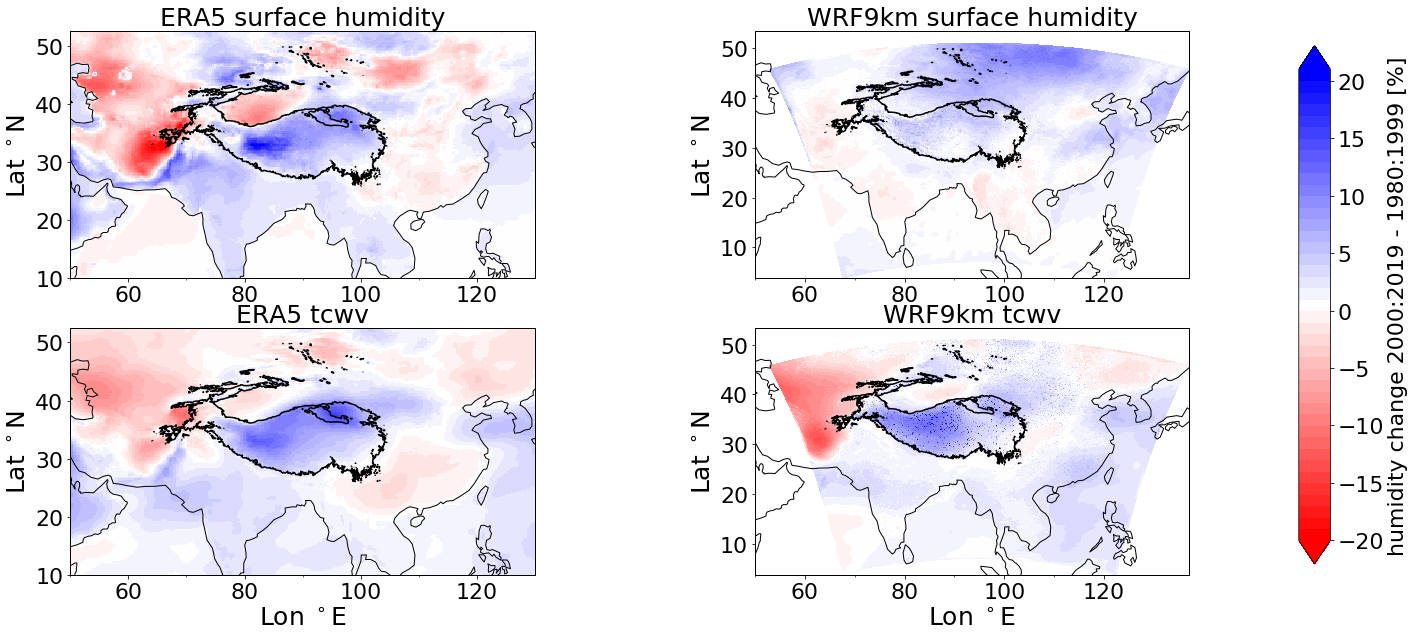

In [35]:
import matplotlib.colors as colors
import cartopy 
import cartopy.crs as ccrs

fig =plt.figure(figsize=(22,10))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]
fs= 25

# customizing of colorbar 
cmap=plt.cm.bwr_r
r = np.arange(-20,22,1)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

#### ERA5 ##### 
lons =era.longitude.values
lats = era.latitude.values


ax1 = plt.subplot(2,2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
m1=ax1.pcolormesh(lons, lats, era_q_recent/ era_q * 100 - 100, norm = norm, cmap = cmap  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title(r'ERA5 surface humidity', fontsize= fs)
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)

ax1 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
m2=ax1.pcolormesh(lons, lats, era_tcwv_recent / era_tcwv * 100 - 100 ,norm = norm, cmap = cmap )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title(r'ERA5 tcwv', fontsize= fs)
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)
ax1.set_xlabel('Lon $^\circ$E',  fontsize=fs)



#### WRF #### 
lons =wrfdata.lon.values
lats = wrfdata.lat.values


ax1 = plt.subplot(2,2, 2, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
m1=ax1.pcolormesh(lons, lats, wrf_q_recent/ wrf_q * 100 - 100, norm = norm, cmap = cmap  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title(r'WRF9km surface humidity', fontsize= fs)
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)

ax1 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
m2=ax1.pcolormesh(lons, lats, wrf_tcwv_recent / wrf_tcwv * 100 - 100 ,norm = norm, cmap = cmap )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title(r'WRF9km tcwv', fontsize= fs)
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)
ax1.set_xlabel('Lon $^\circ$E',  fontsize=fs)

cb_ax1 = fig.add_axes([0.93, 0.14,0.02, 0.72])
cbar = fig.colorbar(m1, cax=cb_ax1, extend = 'both', label = 'humidity change 2000:2019 - 1980:1999 [%]')

plt.rcParams.update({'font.size': 22})

plt.savefig('plots/humidity_changes.png')
plt.show()

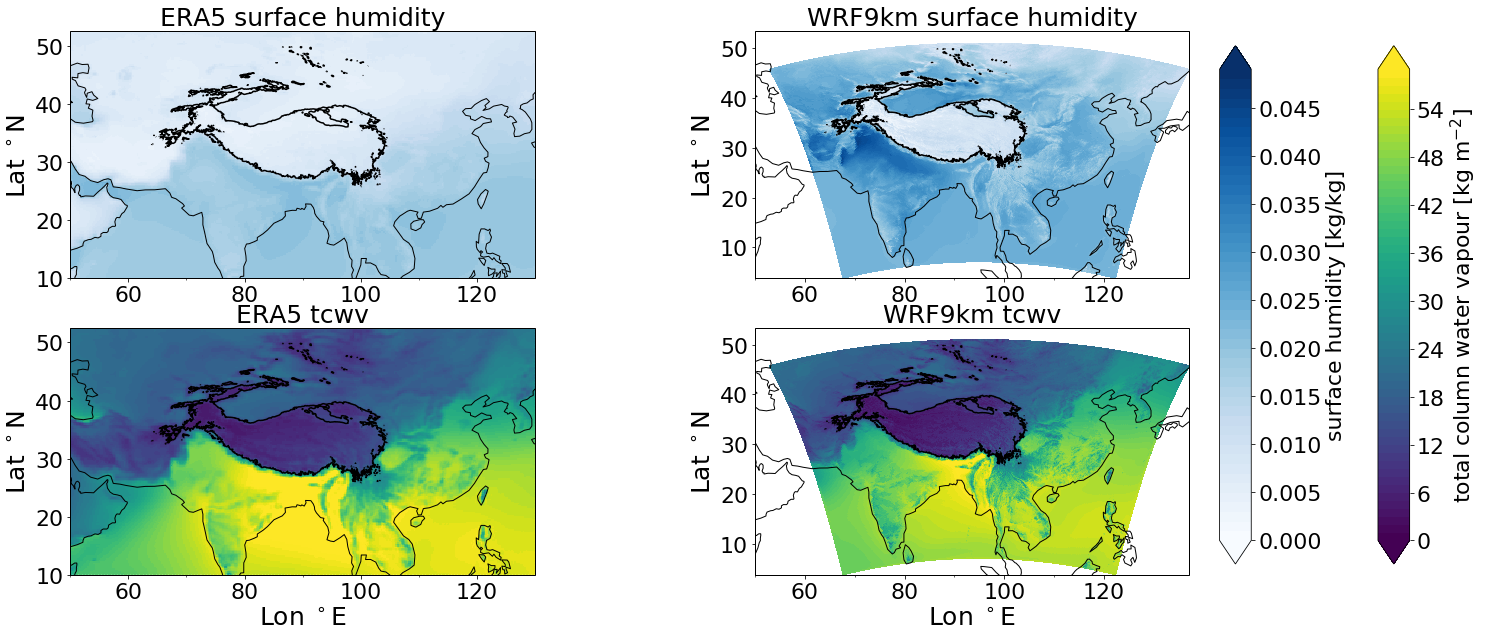

In [92]:
import matplotlib.colors as colors
import cartopy 
import cartopy.crs as ccrs

fig =plt.figure(figsize=(22,10))
xlabels=[50,60,70,80,90,100,110,120]
ylabels= [10,20,30,40,50]
fs= 25

# customizing of colorbar 
cmap=plt.cm.bwr_r
r = np.arange(0,0.05,0.001)
norm = colors.BoundaryNorm(boundaries= r,  ncolors= 256)

r2 = np.arange(0,60,1)
norm2 = colors.BoundaryNorm(boundaries= r2,  ncolors= 256)


#### ERA5 ##### 
lons =era.longitude.values
lats = era.latitude.values


ax1 = plt.subplot(2,2, 1, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
m1=ax1.pcolormesh(lons, lats, era_q_recent/1000, norm = norm, cmap = 'Blues' )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title(r'ERA5 surface humidity', fontsize= fs)
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)


ax1 = plt.subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
m2=ax1.pcolormesh(lons, lats, era_tcwv_recent ,norm = norm2, cmap = 'viridis' )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title(r'ERA5 tcwv', fontsize= fs)
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)
ax1.set_xlabel('Lon $^\circ$E',  fontsize=fs)


#### WRF #### 
lons =wrfdata.lon.values
lats = wrfdata.lat.values

ax1 = plt.subplot(2,2, 2, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
m1=ax1.pcolormesh(lons, lats, wrf_q_recent/1000, norm = norm, cmap = 'Blues'  )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title(r'WRF9km surface humidity', fontsize= fs)
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)

ax1 = plt.subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax1.set_extent([np.nanmin(lons),np.nanmax(lons),np.min(lats),45])
m2=ax1.pcolormesh(lons, lats, wrf_tcwv_recent,norm = norm2, cmap = 'viridis' )
ax1.contour(lo,la, elevations.data.T, [3000], cmap = 'Greys_r')
ax1.coastlines(color = 'black')
ax1.set_title(r'WRF9km tcwv', fontsize= fs)
# axis labels 
ax1.set_xticks(xlabels, xlabels)
ax1.set_yticks(ylabels,ylabels)
ax1.set_ylabel('Lat $^\circ$N',  fontsize=fs)
ax1.set_xlabel('Lon $^\circ$E',  fontsize=fs)




cb_ax1 = fig.add_axes([0.88, 0.14,0.02, 0.72])
cbar = fig.colorbar(m1, cax=cb_ax1, extend = 'both', label = 'surface humidity [kg/kg]')

cb_ax2 = fig.add_axes([0.98, 0.14,0.02, 0.72])
cbar = fig.colorbar(m2, cax=cb_ax2, extend = 'both', label = 'total column water vapour [kg m$^{-2}$]')

plt.rcParams.update({'font.size': 22})


plt.savefig('plots/humidity_wrf_era5.png')
plt.show()

## Binning 

- Attribute each hourly precipitation value of wet events to daily surface temperature bin of 2C bin width (temperature should represent air mass and should therefoe not be on a too short time scale)
- calculate percentiles for each bin size 

In [2]:
keys =  np.arange(-30,40,2).astype(str)
keys = list(map('b'.__add__,keys))
bins = dict.fromkeys(keys, np.array(()))
bins_con = dict.fromkeys(keys, np.array(()))
bins_div = dict.fromkeys(keys, np.array(()))
bins_tp = dict.fromkeys(keys, np.array(()))

In [3]:
testdata = xr.open_dataset('/media/juli/Data/projects/data/ERA5/ERA5_2002-07_PT_GlHrly.nc')

# extract domain and fix unit (from m to mm per hour)                                                                                                  
lc= testdata.coords["longitude"]
la= testdata.coords["latitude"]
precip_tp= testdata.tp.loc[dict(longitude=lc[(lc > 50) & (lc < 135)], latitude=la[(la > 10) & (la < 60)])] * 1000
temp_tp= testdata.t2m.loc[dict(longitude=lc[(lc > 50) & (lc < 135)], latitude=la[(la > 10) & (la < 60)])] - 273.15


In [4]:
# apply additional regional selections 
vimd = xr.open_dataset('../moisture_transport/moisture_transport/cache/era5_monthlymean_clim_moistdiv.nc').vimd[0]


In [6]:
# loop through days in month 
for d in np.arange(1,31):
    # get mean daily surface temperature
    daily_temp = temp_tp.sel(time= (temp_tp['time.day'] == 10) ).mean(dim='time')
    wet_hours = precip_tp.where(precip_tp > 0.1)
    for i in np.arange(-30,40,2):
        ii = i+2
        bin_values=wet_hours.where( (daily_temp >= i)  &  (daily_temp <= ii)    ).data
        values = bin_values[~np.isnan(bin_values)]

        # attribute to bin
        bins['b' + str(i)] = np.append(bins['b' + str(i)], values)
        
        # convergence zone
        bin_values = wet_hours.where( (daily_temp >= i)  &  (daily_temp <= ii)  )
        convergence  = bin_values.where(-vimd > 0 ).data
        values = convergence[~np.isnan(convergence)]
        bins_con['b' + str(i)] = np.append(bins_con['b' + str(i)], values)
        
        # divergence zone
        divergence  = bin_values.where(-vimd < 0 ).data
        values = divergence[~np.isnan(divergence)]
        bins_div['b' + str(i)] = np.append(bins_div['b' + str(i)], values)

In [7]:
# save distributions 

xbins = xr.Dataset(bins)
xbins.to_netcdf('cc_bins_2002.nc') 

xbins = xr.Dataset(bins_con)
xbins.to_netcdf('cc_bins_con_2002.nc')

xbins = xr.Dataset(bins_div)
xbins.to_netcdf('cc_bins_div_2002.nc')

In [315]:
percentiles99 = np.zeros((len(bins.keys())))
percentiles95 = np.zeros((len(bins.keys())))
percentiles90 = np.zeros((len(bins.keys())))

for idx,i in enumerate(np.arange(-30,40,2)): 
    if bins_con[i].size > 0:
        percentiles99[idx] = np.percentile(bins_con[i], 99 ) 
        percentiles95[idx] =  np.percentile(bins_con[i], 95 ) 
        percentiles90[idx] = np.percentile(bins_con[i], 90 ) 

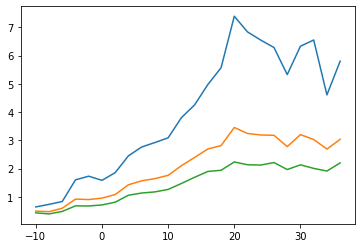

In [316]:
plt.plot(np.arange(-10,38,2), percentiles99[10:-1])
plt.plot(np.arange(-10,38,2), percentiles95[10:-1])
plt.plot(np.arange(-10,38,2), percentiles90[10:-1])

#plt.plot(np.arange(-11,38,2), cc(25, percentiles90[0]))
plt.show()

In [317]:
percentiles99 = np.zeros((len(bins.keys())))
percentiles95 = np.zeros((len(bins.keys())))
percentiles90 = np.zeros((len(bins.keys())))

for idx,i in enumerate(np.arange(-30,40,2)): 
    if bins_div[i].size > 0:
        percentiles99[idx] = np.percentile(bins_div[i], 99 ) 
        percentiles95[idx] =  np.percentile(bins_div[i], 95 ) 
        percentiles90[idx] = np.percentile(bins_div[i], 90 )  

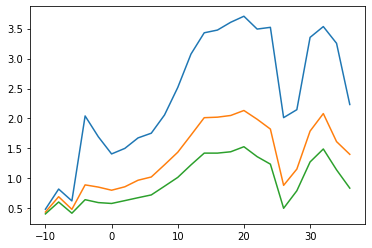

In [318]:
plt.plot(np.arange(-10,38,2), percentiles99[10:-1])
plt.plot(np.arange(-10,38,2), percentiles95[10:-1])
plt.plot(np.arange(-10,38,2), percentiles90[10:-1])
#plt.plot(np.arange(-11,38,2), cc(25, percentiles90[0]))
plt.show()

In [215]:
def cc(iterations, start):
    values = [start]
    for e in np.arange(iterations):
        val= values[-1]
        values.append(val + 0.07*val)
    
    return values 

## Calculate scaling rates for each grid point 